#Bibliotecas


In [ ]:
import pandas as pd
import requests as rq
import json
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from warnings import simplefilter
from google.colab import drive
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error
import itertools
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
simplefilter(action='ignore', category=FutureWarning)

#Carregamento dos dados

In [ ]:
df = pd.read_csv('drive/MyDrive/Projeto TCC Pós Graduação/nfl-big-data-bowl-2020/train.csv', low_memory=False)

#Pré Processamento dos dados

##Adição de coluna ResultAfterMove
Adicionado nova feature ao dataset mapeando o resultado de cada jogada, a jogada pode ter resultado em avanço em campo, ganho de novas descidas, turn over on Downs, quando a bola retorna para o outro time ou retornar nenhum avanço ou recuo em campo. 

In [ ]:
df['ResultAfterMove'] = np.where(df['Yards']<0,'Perda de jardas',np.where(df['Yards']>=df['Distance'],'FirstDown',np.where(df['Down']==4,'Turn Over on Downs',np.where(['Yards']==0,'Sem avanço','Avanco sem First Down'))))

##Colunas Key e IsHomeTeam
Adicionado coluna Key, concatenando GameID e PlayID, a qual será utilizada como indice do dataset. A coluna IsHomeTeam foi adicionada, mapenado em cada jogada se o time com posse de bola era o time mandante do jogo ou não. 

In [ ]:
df['key'] = df['GameId'].map(str)+'-'+df['PlayId'].map(str)
df['IsHomeTeam'] = df['Team'].map({'away': 0, 'home': 1})
df = df.drop(df[['GameId','PlayId','Team']],axis=1)
df = df.set_index('key')

##Separação entre atributos e variável alvo

In [ ]:
X,y = df.drop('Yards',axis=1), df['Yards']

##Plot de distruição atributo alvo

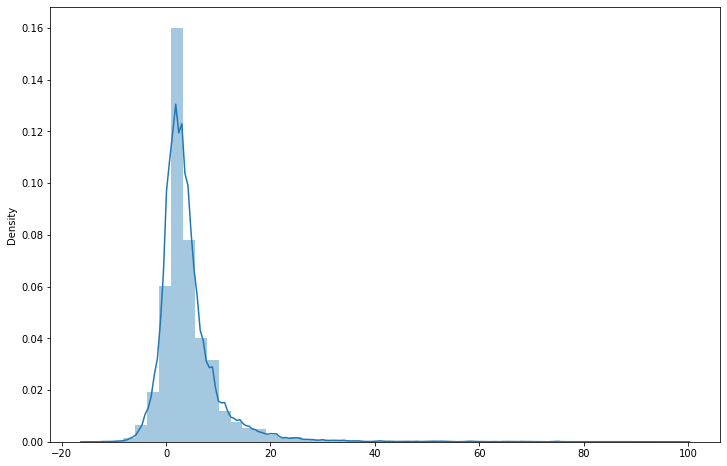

In [ ]:
ax = sns.distplot(y.values)
ax.figure.set_size_inches(12,8)

##Plot CountValues por resultado de jogada e temporada.

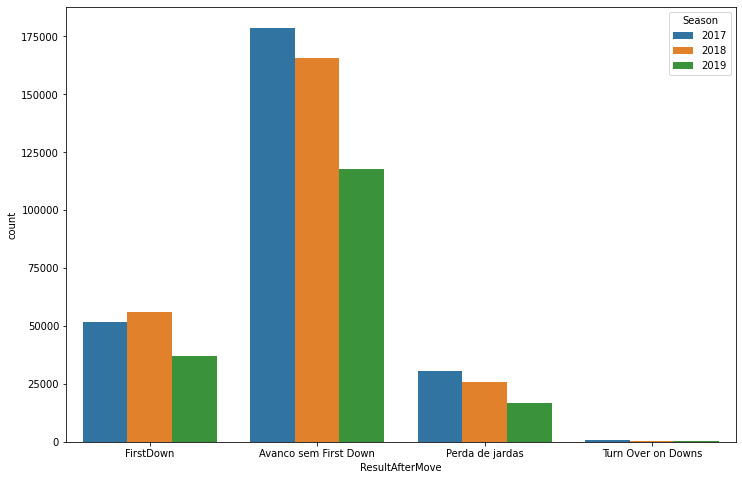

In [ ]:
ax = sns.countplot(df['ResultAfterMove'],hue=df['Season'])
ax.figure.set_size_inches(12, 8)

##Separação do dataset entre Treino e Teste
Utilização de y para estratificação dos dados e divisão entre 70/30

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, stratify=y)

##Validação de colunas com informações nulas

In [ ]:
sum_na = X_train.isna().sum().sort_values(ascending=False)
sum_na[sum_na>0]

WindDirection        73292
WindSpeed            64351
Temperature          44390
GameWeather          42155
StadiumType          29218
FieldPosition         5975
Humidity              4294
OffenseFormation        65
Dir                     20
DefendersInTheBox       16
Orientation             16
dtype: int64

##Processamento da coluna WindSpeed
Função desenvolvida para aplicar a padronização dos dados da coluna WindSpeed seguindo a seguinte lógica:
Em casos que são numéricos, retornará o valor, caso o valor numérico contenha texto junto, ex: mph, retornará apenas o valor numérico. Em casos de range de valores, por exemplo "30 - 50", será realizado uma média entre os dois valores e o valor será o retorno deste calculo.

In [ ]:
def windspeed(x):
    x=str(x)
    if x.isdigit():
        return int(x)
    elif (x.isalpha()):
        return 0
    elif (x.isalnum()):
        return int(x.upper().split('M')[0])
    elif '-' in x:
        return int((int(x.split('-')[0])+int(x.split('-')[1]))/2)
    else:
        return 0

##Aplicação da função e preenchimento de valores nulos com a média da coluna.

In [ ]:
#dataset de treino
X_train['WindSpeed']=X_train['WindSpeed'].apply(windspeed)
X_train['WindSpeed'].fillna(X_train['WindSpeed'].mean(),inplace=True)

In [ ]:
#dataset de teste
X_test['WindSpeed']=X_test['WindSpeed'].apply(windspeed)
X_test['WindSpeed'].fillna(X_test['WindSpeed'].mean(),inplace=True)

In [ ]:
X_train['WindSpeed'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24])

In [ ]:
X_test['WindSpeed'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24])

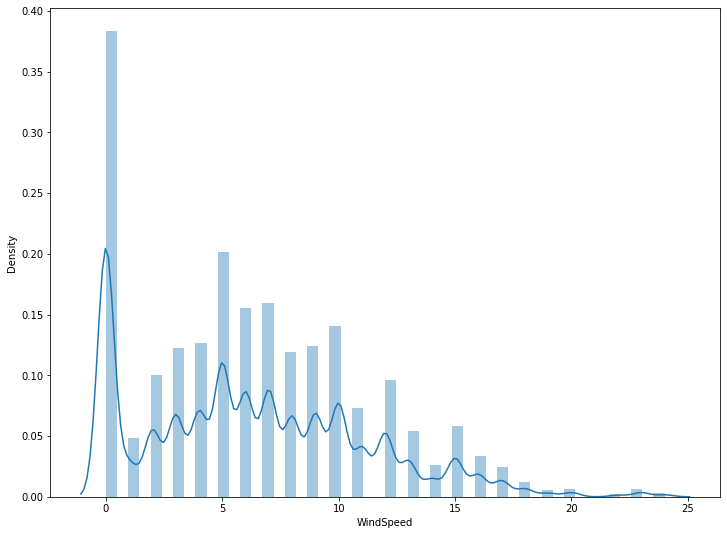

In [ ]:
ax = sns.distplot(X_train['WindSpeed'])
ax.figure.set_size_inches(12,9)

##Processamento da coluna Wind Direction. 
Função para limpeza da coluna Wind Direction, devido a diversisdade de valores, foram mapeadas todas as possibilidades existentes no dataset e a função abaixo fará a substituição destes entre North, South, West, East, South West e North West.

In [ ]:
def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM N' in wd:
        return 'north'
    if wd == 'S' or 'FROM S' in wd:
        return 'south'
    if wd == 'W' or 'FROM W' in wd:
        return 'west'
    if wd == 'E' or 'FROM E' in wd:
        return 'east'
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'south west'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'south east'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'north west'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'north east'
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'N/A'

#Aplicação da função nos dados de treino
X_train['WindDirection'] = X_train['WindDirection'].apply(clean_wind_direction)

In [ ]:
#Aplicação da função nos dados de teste
X_test['WindDirection'] = X_test['WindDirection'].apply(clean_wind_direction)

In [ ]:
X_train['WindDirection'].unique()

array(['north east', 'north west', 'west', 'N/A', 'south', 'east',
       'south east', 'north', 'south west'], dtype=object)

##Processamento das colunas Humidity e Temperature
Aplicado o preenchimento de valores nulos das colunas Humidity e Temperature utilizando o método ffill, 'Forward Fill', o qual realiza o preenchimento replicando o valor da linha anterior. Devido a forma de preenchimento destes dados, com poucas variações em um curto espaço de tempo, o método retorna um bom resultado para tratamento de valores nulos.

In [ ]:
#Dados de treino
X_train['Humidity'].fillna(method='ffill', inplace=True)
X_train['Temperature'].fillna(method='ffill', inplace=True)

In [ ]:
#Dados de teste
X_test['Humidity'].fillna(method='ffill', inplace=True)
X_test['Temperature'].fillna(method='ffill', inplace=True)

##Processamento de colunas Orientation, Dir, Deffenders e OffenseFormation
Preenchimento das colunas usando a média da coluna para as variáveis Orientation, Dir, DeffendersInTheBox e OffenseFormation. 
Para a coluna OffenseFormation, a utilização de jogadas é algo totalmente importante, particular e decisivo em um jogo, porém existem jogadas personalizadas em cada time, então, para os valores em branco, foi assumido o valor UNKNOWN.

In [ ]:
na_map = {
    'Orientation': X_train['Orientation'].mean(),
    'Dir': X_train['Dir'].mean(),
    'DefendersInTheBox': np.math.ceil(X_train['DefendersInTheBox'].mean()),
    'OffenseFormation': 'UNKNOWN'
}

#Preenchimento no dataset de teste
X_train.fillna(na_map, inplace=True)

In [ ]:
#Preenchimento no dataset de treino
X_test.fillna(na_map, inplace=True)

##Processamento da coluna Game Weather
Devido a alta diversidade de valores, totalmente fora de um padrão, para a padronização desta variável, foram mapeados todos os valores possíveis e agrupados enre Rain, Overcast, Clear, Snow e Controlled, para casos de estadios fechados, onde o clima não terá tanta influência.

In [ ]:
def group_game_weather(weather):
    rain = ['Rainy', 'Rain Chance 40%', 'Showers',
            'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
            'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']

    overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
                'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
                'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
                'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
                'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
                'Partly Cloudy', 'Cloudy']

    clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
             'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
             'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
             'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
             'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
             'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']

    snow  = ['Heavy lake effect snow', 'Snow']

    controlled  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 'rain'
    elif weather in overcast:
        return 'overcast'
    elif weather in clear:
        return 'clear'
    elif weather in snow:
        return 'snow'
    elif weather in controlled:
        return 'controlled'
    
    return 'controlled'

In [ ]:
#Aplicação da função nos dados de treino
X_train['GameWeather'] = X_train['GameWeather'].apply(group_game_weather)
X_train['FieldPosition'] = np.where(X_train['YardLine'] == 50, X_train['PossessionTeam'], X_train['FieldPosition'])

In [ ]:
#Aplicação da função nos dados de teste
X_test['GameWeather'] = X_test['GameWeather'].apply(group_game_weather)
X_test['FieldPosition'] = np.where(X_test['YardLine'] == 50, X_test['PossessionTeam'], X_test['FieldPosition'])

##Processamento da coluna Stadium Type
Para esta variável, temos um cenário parecido com a Game Weather, existem vários valores que, no fim, possuem o mesmo significado. Para tal, foram mapeados todos os valores possíveis da coluna e agrupados entre Outdoor, Indoor_Closed, Indoor_Open, Dome_Closed, Dome_Open, casos nulos serão preenchidos com a tag unknown.

In [ ]:
#Para a coluna de Stadium Type, também foi realizado o agrupado dos valores, visto que temos valores que diferem, porém possuem o mesmo significado.
def group_stadium_types(stadium):
    outdoor = ['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
               'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
               'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']

    indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
                    'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',]

    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']

    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 'outdoor'
    elif stadium in indoor_closed:
        return 'indoor closed'
    elif stadium in indoor_open:
        return 'indoor open'
    elif stadium in dome_closed:
        return 'dome closed'
    elif stadium in dome_open:
        return 'dome open'
    else:
        return 'unknown'
#Aplicação nos dados de treino.   
X_train['StadiumType'] = X_train['StadiumType'].apply(group_stadium_types)

In [ ]:
#Aplicação nos dados de teste
X_test['StadiumType'] = X_test['StadiumType'].apply(group_stadium_types)

##Processamento coluna PlayerHeight
Para esta coluna, como o dado já traz uma informação numérica com a altura do jogador, temos apenas algumas situações onde existem alguma string acompanhando, neste caso, foi removido o string que acompanhava o caracter numérico e, posteriormente, a coluna poderá ser transformada em um atributo numérico. 

In [ ]:
#Aplicação no dados de treino
X_train['PlayerHeight']=X_train['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))

In [ ]:
#Aplicação nos dados de teste
X_test['PlayerHeight']=X_test['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))

In [ ]:
X_train['PlayerHeight'].unique()

array([3. , 5. , 4.5, 7.5, 7. , 6.5, 5.5, 6. , 3.5, 8. , 4. ])

##Processamento coluna DefensePersonnel
Para esta coluna, onde temos a informação de quais e quantos jogadores compõem a linha de defesa do time, o dado encontra-se no formato do exemplo "1 DL, 3 LB, 4 BL, 2 OL", para efetuar a limpeza e processamento, foi aplicado a técnica de separar cada posição em uma coluna distinta, retornando quantos jogadores existem em cada uma delas, para tal, primeiro foi efetuado o split dos dados pelo espaço aplicado e depois coletado apenas o valor inteiro restante, cada valor deste foi armazenado em uma variável auxiliar (u, v, x e y) e na sequência, as novas colunas foram atribuídas ao dataset, tendo o seu nome conforme o nome da posição do jogador.

In [ ]:
def process_defense(x):
    num=[]
    num=x.split(',')
    dl=int(num[0].split(' ')[0])
    lb=int(num[1].split(' ')[1])
    db=int(num[2].split(' ')[1])
    if(len(num)>3):
         ol=int(num[3].split(' ')[1])
    else:
         ol=0
    return [dl,lb,db,ol]

#Aplicação nos dados de treino
values=X_train['DefensePersonnel'].apply(process_defense)
u,v,x,y=list(map(list,zip(*values)))

X_train['DL']=u
X_train['LB']=v
X_train['BL']=x
X_train['OL']=y
X_train.drop(['DefensePersonnel'],axis=1,inplace=True)

In [ ]:
#Aplicação nos dados de teste
values=X_test['DefensePersonnel'].apply(process_defense)
u,v,x,y=list(map(list,zip(*values)))

X_test['DL']=u
X_test['LB']=v
X_test['BL']=x
X_test['OL']=y
X_test.drop(['DefensePersonnel'],axis=1,inplace=True)

##Enconding dos dados
Nesta etapa, é realizado o enconding dos dados, primeiramente, existe a tentativa de converter todas as colunas que são diferentes do tipo INT para float16, as colunas que não puderem ser convertidas, retornarão no except e serão adicionadas em uma lista, a qual é passada ao método LabelEncoder, onde os valores das colunas serão rotulados com um numero inteiro para cada valor possível. 

In [ ]:
#Aplicação nos dados de treino
ColumnsToEncoding=[]
for c in X_train.columns:
    if(X_train[c].dtype != int):
            try:
                X_train[c]=X_train[c].astype('float16')
            except:
                ColumnsToEncoding.append(c)

lbdic={}
for c in ColumnsToEncoding:
    lb=LabelEncoder()
    lb=lb.fit(X_train[c].values)
    lbdic[c]=lb
    X_train[c]=lb.transform(X_train[c].values)

In [ ]:
#Aplicação nos dados de teste
ColumnsToEncoding=[]
for c in X_test.columns:
    if(X_test[c].dtype != int):
            try:
                X_test[c]=X_test[c].astype('float16')
            except:
                ColumnsToEncoding.append(c)

lbdic={}
for c in ColumnsToEncoding:
    lb=LabelEncoder()
    lb=lb.fit(X_test[c].values)
    lbdic[c]=lb
    X_test[c]=lb.transform(X_test[c].values)

In [ ]:
X_test.head(5)

,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,...,Temperature,Humidity,WindSpeed,WindDirection,ResultAfterMove,IsHomeTeam,DL,LB,BL,OL
key,,,,,,,,,,,,,,,,,,,,,
2017102910-20171029100579,28.37500,28.125000,2.449219,0.970215,0.300049,178.250,335.500,2508109,362,97,...,68.0,70.0,0,0,0,0,2,4,5,0
2018120910-20181209103960,32.40625,27.765625,5.160156,1.459961,0.509766,96.625,146.375,2561006,1628,36,...,54.0,72.0,3,4,2,1,4,2,5,0
2018093008-20180930080102,68.37500,22.234375,4.218750,3.009766,0.419922,73.000,90.000,2532975,2050,3,...,54.0,72.0,0,0,0,0,4,2,5,0
2019112409-20191124090051,34.87500,31.718750,0.620117,1.780273,0.059998,250.250,154.375,2495481,1562,93,...,38.0,90.0,16,4,0,1,3,3,5,0
2018100709-20181007091013,54.90625,38.093750,0.189941,0.540039,0.020004,242.500,185.000,79848,1614,27,...,79.0,77.0,6,7,0,1,4,2,5,0


##Scaler de dados
Para padronizar os valores do dataset, fora tentado 3 métodos diferentes e avaliado a melhor performance dentre eles, para este cenário, o método MinMaxScaler apresentou uma performance superior aos demais. 

In [ ]:
#Aplicação de scaler nos dados. RobustScaler apresentou a melhor performance nos modelos testados.
SS = StandardScaler()
MM = MinMaxScaler()
RS = RobustScaler()

X_train_scaled = MM.fit_transform(X_train)
X_test_scaled = MM.fit_transform(X_test)

#Treinamento de modelos

##XGBoost Dados originais
Como primeiro teste, o regressor XGBoost foi treinado com os dados antes de ser aplicado o scaler, como parametrização do modelo, foi alterado as informações de Max_Depth e ETA, os seguintes resultados foram obtidos. 

Mean Squared Error:  0.15127884465183353

R2 Score:  0.9963645894442287

Mean Absolute Error:  0.12070613972205342

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score


# Transformando conjuntos de treinamento e teste em DMatrices
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Definindo parâmetros do modelo
params = {
    "objective":"reg:squarederror",
    "max_depth":20,
    "eta":0.1,
    "eval_metric":"rmse"
}

# Treinando o modelo
model_n = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

# Fazendo previsões no conjunto de teste
preds = model_n.predict(dtest)

Mean Squared Error:  0.15127884465183353
R2 Score:  0.9963645894442287


In [ ]:
# Avaliar o modelo
mse_n = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
mae_n = mean_absolute_error(y_test, preds)

print("Mean Squared Error: ", mse_n)
print("R2 Score: ", r2)
print("Mean Absolute Error: ", mae_n)

Mean Squared Error:  0.15127884465183353
R2 Score:  0.9963645894442287
Mean Absolute Error:  0.12070613972205342


##XGBoost Dados escalados
Em um segundo teste, o regressor XGBoost foi treinado com os dados já processados pelo MinMaxScaler, mantendo a mesma parametrização anterior e os seguintes resultados foram obtidos.

Mean Squared Error:  0.09624333056625436

R2 Score:  0.997688414286095

Mean Absolute Error:  0.1150129628115245

In [ ]:
# Transformando conjuntos de treinamento e teste em DMatrices
dtrain_scaled = xgb.DMatrix(data=X_train_scaled, label=y_train)
dtest_scaled = xgb.DMatrix(data=X_test_scaled, label=y_test)

# Definindo parâmetros do modelo
params = {
    "objective":"reg:squarederror",
    "max_depth":20,
    "eta":0.1,
    "eval_metric":"rmse"
}

# Treinando o modelo
model_n_scaled = xgb.train(params=params, dtrain=dtrain_scaled, num_boost_round=100)

# Fazendo previsões no conjunto de teste
preds_scaled = model_n_scaled.predict(dtest_scaled)

In [ ]:
# Avaliar o modelo
mse_n_scaled = mean_squared_error(y_test, preds_scaled)
r2_scaled = r2_score(y_test, preds_scaled)
mae_n_scaled = mean_absolute_error(y_test, preds_scaled)

print("Mean Squared Error: ", mse_n_scaled)
print("R2 Score: ", r2_scaled)
print("Mean Absolute Error: ", mae_n_scaled)

Mean Squared Error:  0.09624333056625436
R2 Score:  0.997688414286095
Mean Absolute Error:  0.1150129628115245


##Robust Scaler: 
MSE 1.23
R2 97%
MAE 0.28
##MinMax Scaler - Melhor resultado
MSE 0.09
R2 99,7%
MAE 0.11
##Standard Scaler
MSE 1.94
R2 95,3%
MAE 0.35


In [ ]:
df_results = pd.DataFrame(y_test)
df_results['Predicted'] = preds_scaled

In [ ]:
df_results['Erro'] = df_results['Yards']-df_results['Predicted']
df_results

,Yards,Predicted,Erro
key,,,
2017111908-20171119081292,5,4.993236,0.006764
2017120311-20171203111632,3,2.967730,0.032270
2019092906-20190929060096,8,7.605905,0.394095
2018092400-20180924002573,-2,-1.879058,-0.120942
2019112400-20191124002227,1,1.026600,-0.026600
...,...,...,...
2019102003-20191020033879,6,5.975643,0.024357
2019092900-20190929000845,16,15.960672,0.039328
2019100602-20191006020780,2,2.005044,-0.005044


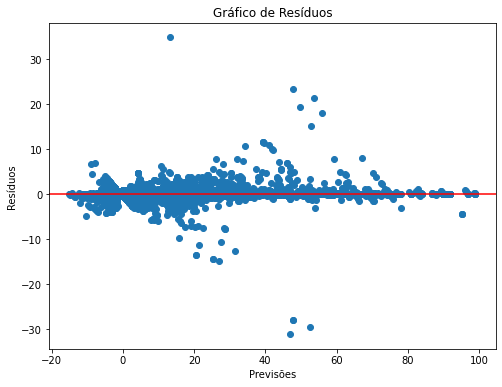

In [ ]:
# Plot do gráfico de resíduos do modelo.
residuals = y_test - preds_scaled

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(preds_scaled, residuals)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos')
plt.show()

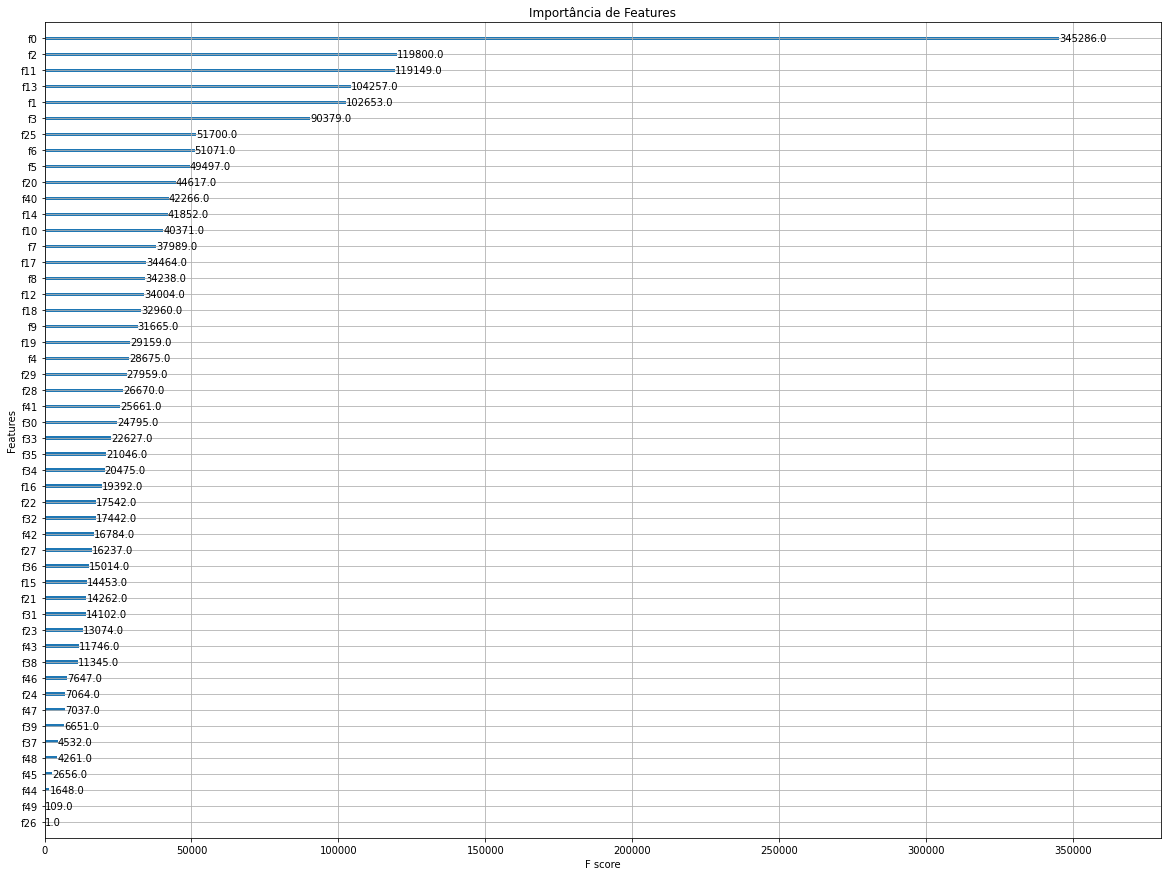

In [ ]:
#Grafico de importância de features
fig = plt.figure(figsize=(20, 15))
xgb.plot_importance(model_n_scaled, ax=plt.gca())
plt.title("Importância de Features")
plt.show()

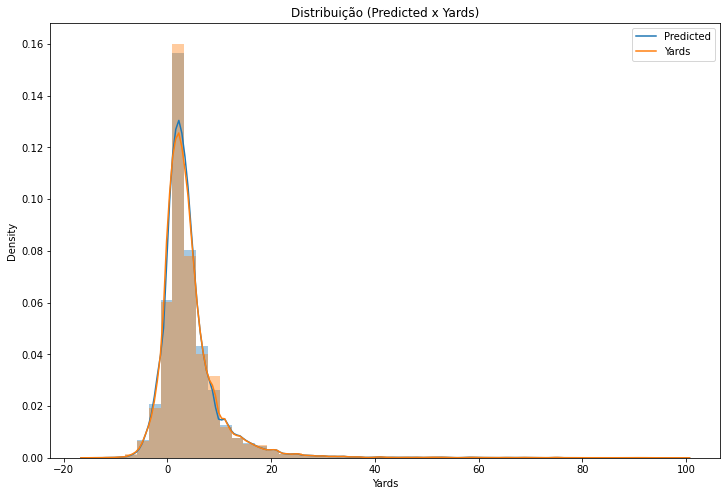

In [ ]:
#Distribuição de jardas entre dados de teste e predições
graphs = []
ax = sns.distplot(preds_scaled,)
ax = sns.distplot(y_test.values)
plt.legend(labels=["Predicted","Yards"])
plt.title('Distribuição (Predicted x Yards)')
plt.xlabel('Yards')
ax.figure.set_size_inches(12,8)

##LightGBM

In [ ]:
import lightgbm as lgb

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test)
model_gbm = lgb.train(params, train_data, num_boost_round=100)

preds_gbm = model_gbm.predict(X_test_scaled)


# Avaliar o modelo
mse_gbm = mean_squared_error(y_test, preds_gbm)
r2_gbm = r2_score(y_test, preds_gbm)

print("Mean Squared Error: ", mse_gbm)
print("R2 Score: ", r2_gbm)

Mean Squared Error:  8.5610205403529
R2 Score:  0.7941521572905488
